In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import Huber
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

In [2]:
# fetch data from Yahoo Finance
ticker = "^NDX"  # NASDAQ 100
data = yf.download(ticker, period="max", interval="1d")  # daily data
data = data[['Close']]

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [3]:
data

Price,Close
Ticker,^NDX
Date,
1985-10-01,112.139999
1985-10-02,110.824997
1985-10-03,110.870003
1985-10-04,110.074997
1985-10-07,108.199997
...,...
2025-03-19,19736.660156
2025-03-20,19677.609375


In [4]:
data.shape

(9948, 1)

In [5]:
# normalizing data using scaler
scaler = MinMaxScaler()

In [6]:
# splitting data into train, validation and test sets
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.15)
test_size = len(data) - train_size - val_size

In [7]:
size_df = pd.DataFrame({
    'Set': ['Training', 'Validation', 'Testing'],
    'Size': [train_size, val_size, test_size]
})
size_df

,Set,Size
0,Training,6963
1,Validation,1492
2,Testing,1493


In [8]:
train_data = data.iloc[:train_size]
val_data = data.iloc[train_size:train_size + val_size]
test_data = data.iloc[train_size + val_size:]

### Control Mechanism for Proper Scaling

In [9]:
train_scaled = scaler.fit_transform(train_data)
sample_test_values = test_data.iloc[:5]  # taking the first 5 test samples
scaled_sample = scaler.transform(sample_test_values)

In [10]:
inverse_transformed_sample = scaler.inverse_transform(scaled_sample)

In [11]:
comparison_df = pd.DataFrame({
    "Original": sample_test_values["Close"].values.flatten(),
    "Scaled": scaled_sample.flatten(),
    "Inverse Transformed": inverse_transformed_sample.flatten()
})

print(comparison_df)


      Original    Scaled  Inverse Transformed
0  7680.720215  1.647296          7680.720215
1  7689.720215  1.649254          7689.720215
2  7713.490234  1.654424          7713.490234
3  7810.709961  1.675570          7810.709961
4  7784.410156  1.669850          7784.410156


In [12]:
# IMPORTANT NOTE : fit the scaler only on the training data
train_scaled = scaler.fit_transform(train_data)
val_scaled = scaler.transform(val_data)
test_scaled = scaler.transform(test_data)

In [13]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

In [14]:
seq_length = 60 # lookback period (days)

In [15]:
# create sequences for training, validation, and test sets
X_train, y_train = create_sequences(train_scaled, seq_length)
X_val, y_val = create_sequences(val_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

In [16]:
# LSTM model
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(100, return_sequences=False),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [17]:
# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [18]:
history = model.fit(X_train, y_train, epochs=200, batch_size=32, 
                    validation_data=(X_val, y_val), callbacks=[early_stop])

Epoch 1/200
216/216 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.0090 - val_loss: 0.0054
Epoch 2/200
216/216 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 5.6317e-04 - val_loss: 0.0015
Epoch 3/200
216/216 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 5.1493e-04 - val_loss: 0.0052
Epoch 4/200
216/216 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 4.2407e-04 - val_loss: 0.0015
Epoch 5/200
216/216 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 3.4884e-04 - val_loss: 0.0032
Epoch 6/200
216/216 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 3.7274e-04 - val_loss: 0.0070
Epoch 7/200
216/216 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 3.5204e-04 - val_loss: 0.0026
Epoch 8/200
216/216 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 2.8946e-04 - val_loss: 0.0053
Epoch 9/200
216/216 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 3.2423e-04 - val_loss: 5.1988e-04
Epoch 10/200
216/216 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 2.9635e-04 - val_loss: 8.7824e-04
Epoch 11/200
216/216 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 2.7968e-04 -

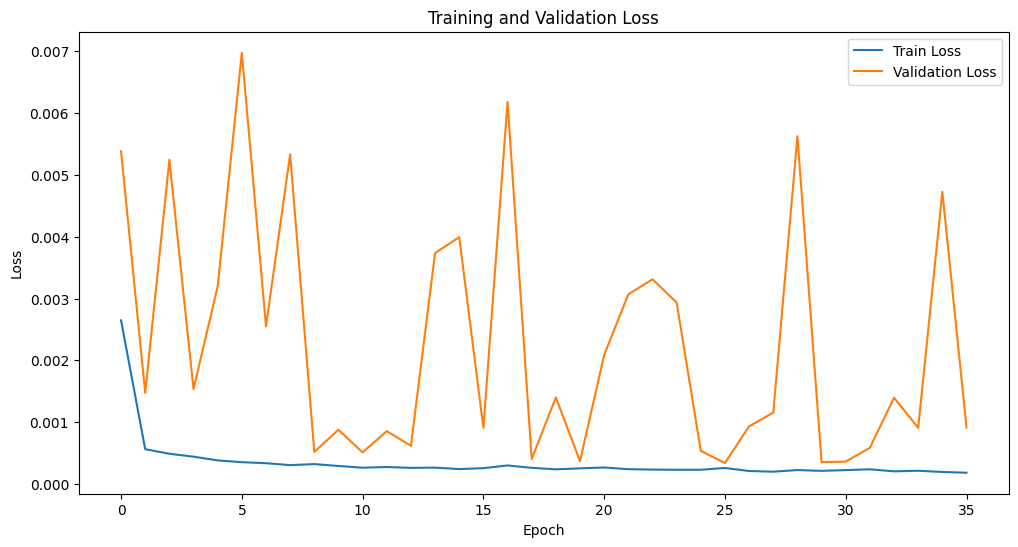

In [19]:
# Plot training & validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [20]:
# predictions
y_pred = model.predict(X_test)

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [21]:
y_pred

array([[1.6637787],
       [1.669339 ],
       [1.6663663],
       ...,
       [3.7624023],
       [3.769862 ],
       [3.8357768]], dtype=float32)

In [22]:
# Inverse transform predictions and actual values
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [23]:
y_pred

array([[ 7756.4985],
       [ 7782.0625],
       [ 7768.3955],
       ...,
       [17405.068 ],
       [17439.365 ],
       [17742.412 ]], dtype=float32)

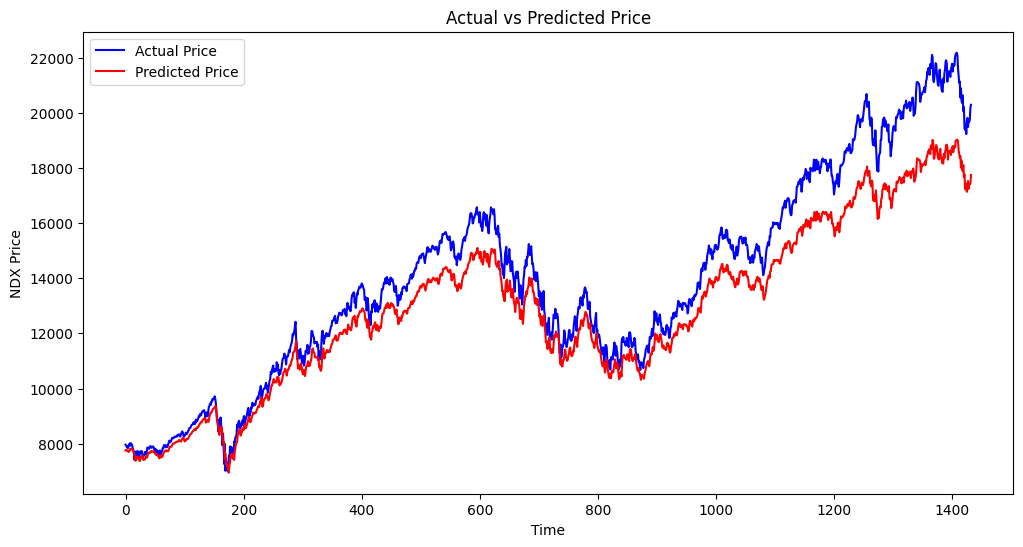

In [24]:
# Actual vs Predicted Price
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Price', color='blue')
plt.plot(y_pred, label='Predicted Price', color='red')
plt.xlabel('Time')
plt.ylabel('NDX Price')
plt.legend()
plt.title('Actual vs Predicted Price')
plt.show()

In [25]:
print("Sample predicted values:", y_pred[:10].flatten())
print("Sample actual values:", y_test[:10].flatten())


Sample predicted values: [7756.4985 7782.0625 7768.3955 7737.9175 7734.611  7698.312  7722.0425
 7765.633  7815.471  7787.0854]
Sample actual values: [7966.93017578 7927.08007812 7888.75976562 7904.12988281 7834.89990234
 7905.12011719 7954.56005859 8010.60986328 7929.87011719 8016.95019531]


In [26]:
print("Scaler Min Value:", scaler.data_min_)
print("Scaler Max Value:", scaler.data_max_)
print("First 10 Predicted Values (Inverse Transformed):", y_pred[:10])
print("First 10 Actual Values (Inverse Transformed):", y_test[:10])



Scaler Min Value: [107.16000366]
Scaler Max Value: [4704.72998047]
First 10 Predicted Values (Inverse Transformed): [[7756.4985]
 [7782.0625]
 [7768.3955]
 [7737.9175]
 [7734.611 ]
 [7698.312 ]
 [7722.0425]
 [7765.633 ]
 [7815.471 ]
 [7787.0854]]
First 10 Actual Values (Inverse Transformed): [[7966.93017578]
 [7927.08007812]
 [7888.75976562]
 [7904.12988281]
 [7834.89990234]
 [7905.12011719]
 [7954.56005859]
 [8010.60986328]
 [7929.87011719]
 [8016.95019531]]


In [27]:
print("Last 10 Predicted Values (Inverse Transformed):", y_pred[-10:])
print("Last 10 Actual Values (Inverse Transformed):", y_test[-10:])


Last 10 Predicted Values (Inverse Transformed): [[17217.818]
 [17418.98 ]
 [17132.104]
 [17439.64 ]
 [17523.062]
 [17239.406]
 [17419.473]
 [17405.068]
 [17439.365]
 [17742.412]]
Last 10 Actual Values (Inverse Transformed): [[19596.01953125]
 [19225.48046875]
 [19704.640625  ]
 [19812.24023438]
 [19483.359375  ]
 [19736.66015625]
 [19677.609375  ]
 [19753.97070312]
 [20180.44921875]
 [20287.82617188]]


In [28]:
# Performance metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
evs = explained_variance_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
directional_accuracy = np.mean((np.sign(np.diff(y_test.flatten())) == np.sign(np.diff(y_pred.flatten())))) * 100
mape_percentage = 100 - mape
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R-squared Score: {r2:.4f}")
print(f"Explained Variance Score: {evs:.4f}")
print(f"Mean Absolute Percentage Error: {mape:.4f}")
print(f"Directional Accuracy: {directional_accuracy:.2f}%")
print(f"Mape Percentage: {mape_percentage:.2f}%")



Mean Squared Error: 1685287.1221
Root Mean Squared Error: 1298.1861
Mean Absolute Error: 1058.0855
R-squared Score: 0.8790
Explained Variance Score: 0.9587
Mean Absolute Percentage Error: 6.7932
Directional Accuracy: 49.23%
Mape Percentage: 93.21%


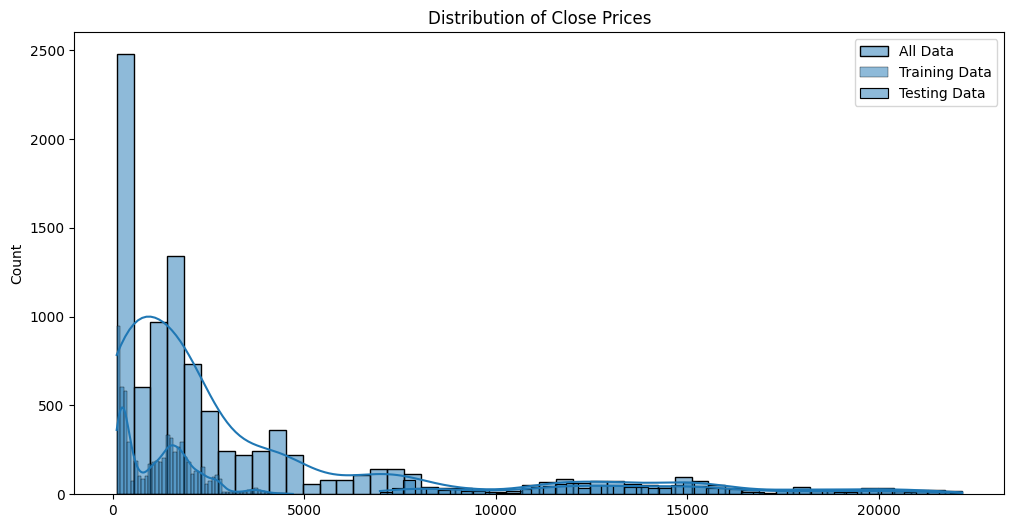

In [29]:
plt.figure(figsize=(12,6))
sns.histplot(data['Close'], bins=50, kde=True, label='All Data', color='blue')
sns.histplot(train_data, bins=50, kde=True, label='Training Data', color='green')
sns.histplot(test_data, bins=50, kde=True, label='Testing Data', color='red')
plt.legend()
plt.title("Distribution of Close Prices")
plt.show()


## Robust scaler with Huber Loss
- Mean Squared Error: 13737556.1339
- Root Mean Squared Error: 3706.4209
- Mean Absolute Error: 3090.2170
- R-squared Score: 0.0135
- Explained Variance Score: 0.6985
- Mean Absolute Percentage Error: 19.8246
- Directional Accuracy: 49.37%
- Mape Percentage: 80.18%

## Robust scaler with Mean Squared Error
- Mean Squared Error: 13654163.4814
- Root Mean Squared Error: 3695.1541
- Mean Absolute Error: 2994.4955
- R-squared Score: 0.0195
- Explained Variance Score: 0.6610
- Mean Absolute Percentage Error: 18.8674
- Directional Accuracy: 49.51%
- Mape Percentage: 81.13%

## Robust scaler with MAE
- Mean Squared Error: 20764473.7637
- Root Mean Squared Error: 4556.8052
- Mean Absolute Error: 3793.8017
- R-squared Score: -0.4911
- Explained Variance Score: 0.5413
- Mean Absolute Percentage Error: 24.2758
- Directional Accuracy: 49.51%
- Mape Percentage: 75.72%

## Min_Max scaler with mean squarred error
- Mean Squared Error: 671628.5036
- Root Mean Squared Error: 819.5294
- Mean Absolute Error: 546.7996
- R-squared Score: 0.9518
- Explained Variance Score: 0.9701
- Mean Absolute Percentage Error: 3.3012
- Directional Accuracy: 48.81%
- Mape Percentage: 96.70%

## Min_Max Scalaer with Huber Loss
- Mean Squared Error: 2141218.2199
- Root Mean Squared Error: 1463.2902
- Mean Absolute Error: 1127.0993
- R-squared Score: 0.8462
- Explained Variance Score: 0.9355
- Mean Absolute Percentage Error: 7.0283
- Directional Accuracy: 50.00%
- Mape Percentage: 92.97%

## Min_Max Scaler with MAE
- Mean Squared Error: 2743430.2382
- Root Mean Squared Error: 1656.3304
- Mean Absolute Error: 1260.5644
- R-squared Score: 0.8030
- Explained Variance Score: 0.9151
- Mean Absolute Percentage Error: 7.8155
- Directional Accuracy: 50.00%
- Mape Percentage: 92.18%